In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import time

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
bs = 1
epochs = 1


Using cpu device


In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        
def get_model():
    model = NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def get_data(training_data, test_data, bs):
    return (
        DataLoader(training_data, batch_size=bs), #, shuffle=True),
        DataLoader(test_data, batch_size=bs),
    )

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    correct = 0
    size = len(train_dl.dataset)
    for epoch in range(epochs):
        model.train()
        for batch, (xb, yb) in enumerate(train_dl):
            # xb, yb = xb.to(device), yb.to(device)
            loss, _ = loss_batch(model, loss_func, xb, yb, opt)
            # correct += bool(model(xb).argmax() == yb)
            
            if batch % 100 == 0:
                current = (batch + 1) * len(xb)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        

        # correct /= len(train_dl.dataset)

        # print(f"Training Error: \n Accuracy: {(100*correct):>0.1f}%")


In [7]:
train_dl, valid_dl = get_data(training_data, test_data, bs)

In [8]:
torch.manual_seed(0)
train_dl, valid_dl = get_data(training_data, test_data, bs)
model, loss_func, opt = get_model()
# Move the model to the device (GPU or CPU)
model = model.to(device)
# torch.save(model.state_dict(), "model.pth")
start_time = time.time()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)
stop_time = time.time()
print(stop_time-start_time)

loss: 2.399653  [    1/60000]
loss: 2.501658  [  101/60000]
loss: 2.463152  [  201/60000]
loss: 2.052140  [  301/60000]
loss: 2.062002  [  401/60000]
loss: 2.140464  [  501/60000]
loss: 2.372984  [  601/60000]
loss: 2.181933  [  701/60000]
loss: 2.231670  [  801/60000]
loss: 2.377624  [  901/60000]
loss: 2.330267  [ 1001/60000]
loss: 2.336244  [ 1101/60000]
loss: 2.223290  [ 1201/60000]
loss: 2.095239  [ 1301/60000]
loss: 2.088407  [ 1401/60000]
loss: 2.224381  [ 1501/60000]
loss: 2.407632  [ 1601/60000]
loss: 2.197903  [ 1701/60000]
loss: 1.949502  [ 1801/60000]
loss: 2.035360  [ 1901/60000]
loss: 2.712936  [ 2001/60000]
loss: 1.718874  [ 2101/60000]
loss: 1.546966  [ 2201/60000]
loss: 2.099437  [ 2301/60000]
loss: 1.999518  [ 2401/60000]
loss: 1.646725  [ 2501/60000]
loss: 2.030183  [ 2601/60000]
loss: 1.635978  [ 2701/60000]
loss: 1.797469  [ 2801/60000]
loss: 2.535216  [ 2901/60000]
loss: 2.357742  [ 3001/60000]
loss: 1.245815  [ 3101/60000]
loss: 1.886808  [ 3201/60000]
loss: 1.85

In [85]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [84]:
len(valid_dl)

10000

In [69]:
debug = iter(valid_dl)
next(debug)[0].shape

torch.Size([1, 1, 28, 28])

In [79]:
correct = 0
start_time = time.time()
times = np.zeros(10)
for i in range(10):
    for batch, (xb, yb) in enumerate(valid_dl):
        pred = model(xb).argmax()
        if batch % 1000 == 0:
            print(f"Complete: {batch/len(valid_dl)+i}", end="\r")
        if pred == yb:
            correct +=1
    stop_time = time.time()
    times[i] = stop_time - start_time
print(np.diff(times).mean())


    

IndexError: index 10 is out of bounds for axis 0 with size 10

In [82]:
np.diff(times).mean()

2.7625641557905407

In [168]:
training_data.targets[:5]

tensor([5, 0, 4, 1, 9])

In [123]:
training_data.data.reshape(60000,784)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [143]:
training_data.data.shape

torch.Size([60000, 28, 28])

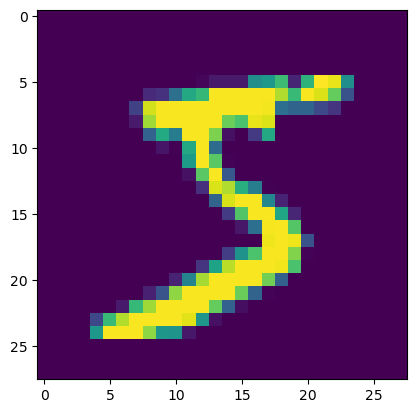

In [128]:
for img in training_data.data.reshape(60000,784):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    break

In [165]:
str(int(training_data.targets[i]))

'8'

In [155]:
torch.concat(training_data.targets, training_data.data.reshape(60000, 784))

TypeError: concat() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [5]:
with open('test_h.h', 'w') as f:
    # Write the initial static declaration
    f.write('#ifndef OUTPUT_H\n#define OUTPUT_H\n\n')
    f.write(f'static double img[{10000}][{784}] = {{\n')
    
    for i,img in enumerate(test_data.data.reshape(10000, 784)[:-1]):  # Flatten images except for the last one
        img_values = ','.join(map(str, img.tolist()))  # Convert tensor to comma-separated string
        f.write("{"+f"{img_values}"+"},\n")  # Write each image as a line in the text file
    img_values = ','.join(map(str, test_data.data.reshape(10000, 784)[-1].tolist()))  # Convert tensor to comma-separated string
    f.write("{"+f"{img_values}"+"}\n")  # Write each image as a line in the text file
        
    # Close the matrix declaration
    f.write('};\n\n')
    f.write('#endif // OUTPUT_H\n')


In [6]:
train_frmt = training_data.data.reshape(6,10000, 784)
train_frmt.shape

torch.Size([6, 10000, 784])

In [20]:
for i,train_set in enumerate(train_frmt):
    with open(f'train_{i}_h.h', 'w') as f:
        # Write the initial static declaration
        f.write(f'#ifndef TRAIN_{i}_H\n#define TRAIN_{i}_H\n\n')
        f.write(f'static double img_set_{i}[{10000}][{784}] = {{\n')
        
        for i,img in enumerate(train_set[:-1]):  # Flatten images except for the last one
            img_values = ','.join(map(str, img.tolist()))  # Convert tensor to comma-separated string
            f.write("{"+f"{img_values}"+"},\n")  # Write each image as a line in the text file
        img_values = ','.join(map(str, train_set[-1].tolist()))  # Convert tensor to comma-separated string
        f.write("{"+f"{img_values}"+"}\n")  # Write each image as a line in the text file
            
        # Close the matrix declaration
        f.write('};\n\n')
        f.write('#endif // TRAIN_{I}_H\n')
 